<a href="https://colab.research.google.com/github/deathperminut/DoctorDegree/blob/main/Paper1/CuadernillosModelos/DenseNetUnivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## CARGAMOS LA BASE DE DATOS

In [ ]:
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0
material-spinners-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/material-spinners-data.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['data.npy.npz', '__notebook__.ipynb']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
MS,Nest,L,rd,So,T,Jex,Jex2,Jex3,Jex4,Kan1,KanS,Hex,kd,KDM = data['MS'],data['Nest'],data['L'],data['rd'],data['So'],data['T'],data['Jex'],data['Jex2'],data['Jex3'],data['Jex4'],data['Kan1'],data['KanS'],data['Hex'],data['kd'],data['KDM']

## JEX 2

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex2.reshape(-1, 1)

In [ ]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:
# Preprocesamiento para adaptar a ResNet
inputs = tf.keras.Input(shape=(39, 39, 1))

In [ ]:

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,168,863 (27.35 MB)

 Trainable params: 131,359 (513.12 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - loss: 0.2075 - mae: 0.2494 - val_loss: 0.0155 - val_mae: 0.0985
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0223 - mae: 0.1157 - val_loss: 0.0109 - val_mae: 0.0831
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0170 - mae: 0.1003 - val_loss: 0.0106 - val_mae: 0.0814
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0160 - mae: 0.0971 - val_loss: 0.0098 - val_mae: 0.0786
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0158 - mae: 0.0962 - val_loss: 0.0104 - val_mae: 0.0788
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0147 - mae: 0.0929 - val_loss: 0.0093 - val_mae: 0.0757
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0144 - mae: 0.0917 - val_loss: 0.0088 - val_mae: 0.0739
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0139 - mae: 0.0892 - val_loss: 0.0084 - val_mae: 0.0715
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

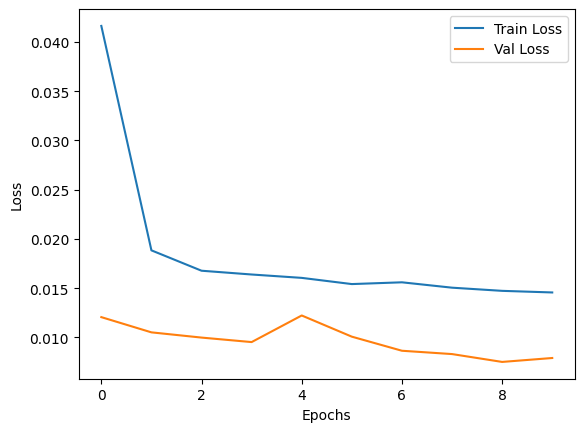

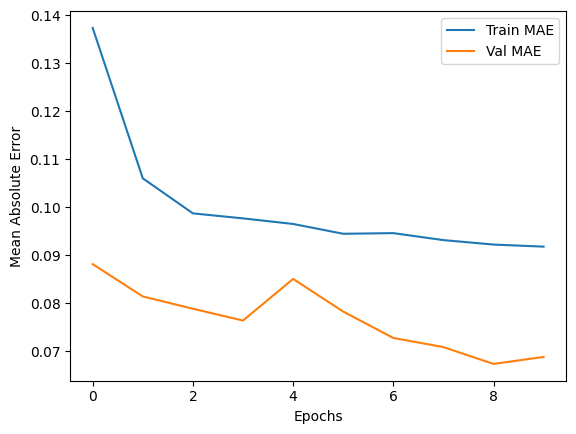

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step


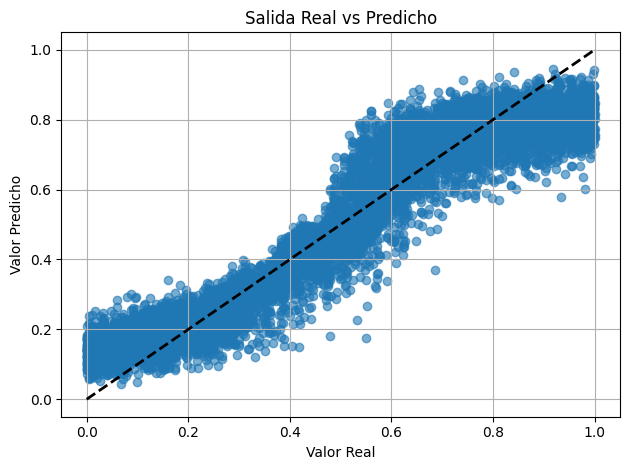

In [ ]:

# Hacer predicciones con el modelo entrenado
y_pred = model.predict(X_val)  # Predicciones en los datos de validación
plt.scatter(y_val_scaled[:, 0], y_pred[:, 0], alpha=0.6)
plt.plot([min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], [min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], 'k--', lw=2)  # Línea de igualdad
plt.title(f'Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.007911147220388113
mae:  0.0688399293432432
rmse:  0.007911147220388113


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

R²: 0.9101
MAPE: 107.84%
SMAPE: 23.18%


## T

In [ ]:
X_ = MS[:,:,:,:]
Y_ = T.reshape(-1, 1)

In [ ]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,168,863 (27.35 MB)

 Trainable params: 131,359 (513.12 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 89s 95ms/step - loss: 0.1932 - mae: 0.2373 - val_loss: 0.0262 - val_mae: 0.1228
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0276 - mae: 0.1171 - val_loss: 0.0246 - val_mae: 0.1055
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0246 - mae: 0.1109 - val_loss: 0.0217 - val_mae: 0.1041
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0237 - mae: 0.1091 - val_loss: 0.0215 - val_mae: 0.1024
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0221 - mae: 0.1052 - val_loss: 0.0210 - val_mae: 0.0993
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0212 - mae: 0.1033 - val_loss: 0.0196 - val_mae: 0.1005
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0203 - mae: 0.1009 - val_loss: 0.0179 - val_mae: 0.0945
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - loss: 0.0195 - mae: 0.0991 - val_loss: 0.0172 - val_mae: 0.0896
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

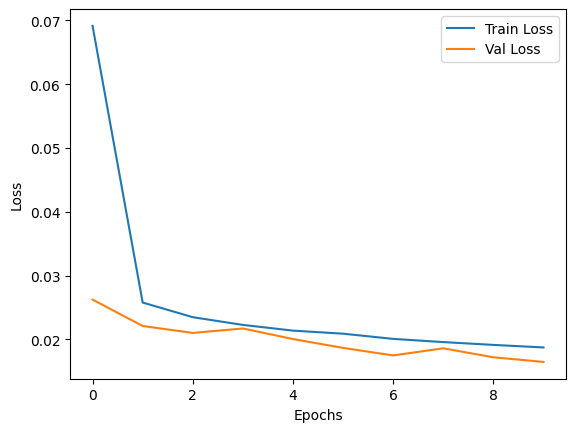

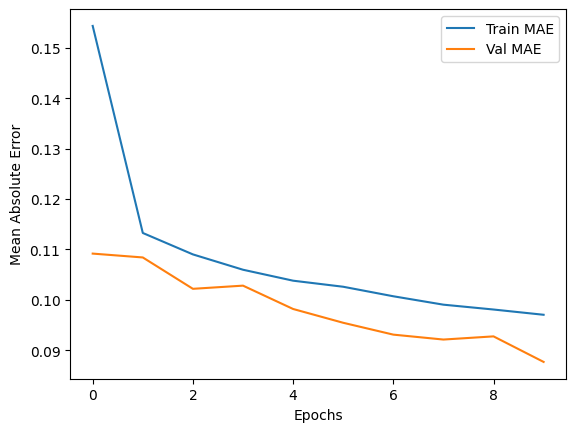

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step


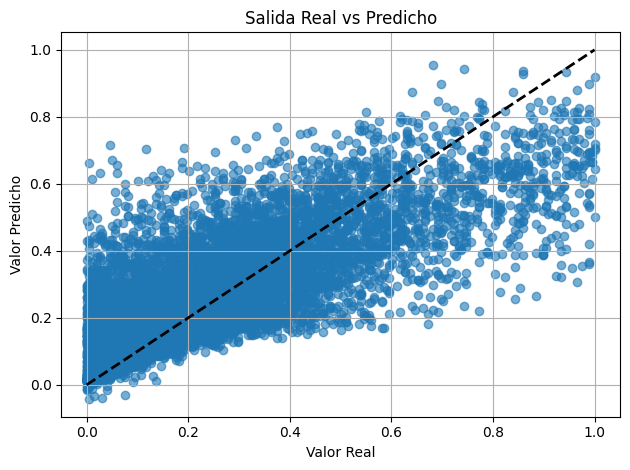

In [ ]:

# Hacer predicciones con el modelo entrenado
y_pred = model.predict(X_val)  # Predicciones en los datos de validación
plt.scatter(y_val_scaled[:, 0], y_pred[:, 0], alpha=0.6)
plt.plot([min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], [min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], 'k--', lw=2)  # Línea de igualdad
plt.title(f'Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.01645948846538376
mae:  0.0876904775709145
rmse:  0.01645948846538376


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

R²: 0.5869
MAPE: 120.30%
SMAPE: 46.19%


## JEX 3

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex3.reshape(-1, 1)

In [ ]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,168,863 (27.35 MB)

 Trainable params: 131,359 (513.12 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 91s 94ms/step - loss: 0.1728 - mae: 0.3071 - val_loss: 0.0806 - val_mae: 0.2475
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0863 - mae: 0.2519 - val_loss: 0.0795 - val_mae: 0.2452
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0815 - mae: 0.2465 - val_loss: 0.0807 - val_mae: 0.2470
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0801 - mae: 0.2450 - val_loss: 0.0793 - val_mae: 0.2451
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0805 - mae: 0.2456 - val_loss: 0.0816 - val_mae: 0.2480
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0803 - mae: 0.2453 - val_loss: 0.0786 - val_mae: 0.2429
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0789 - mae: 0.2423 - val_loss: 0.0795 - val_mae: 0.2448
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0786 - mae: 0.2419 - val_loss: 0.0786 - val_mae: 0.2431
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

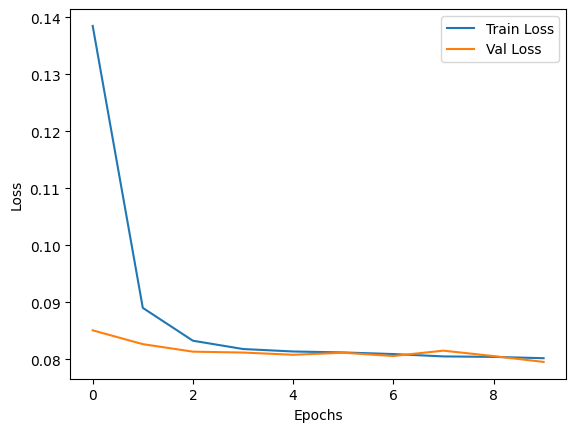

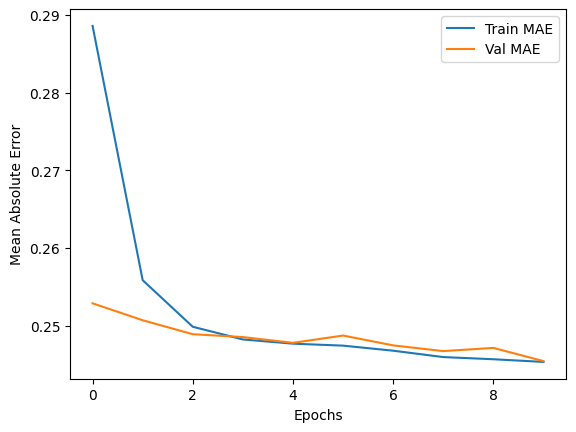

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step


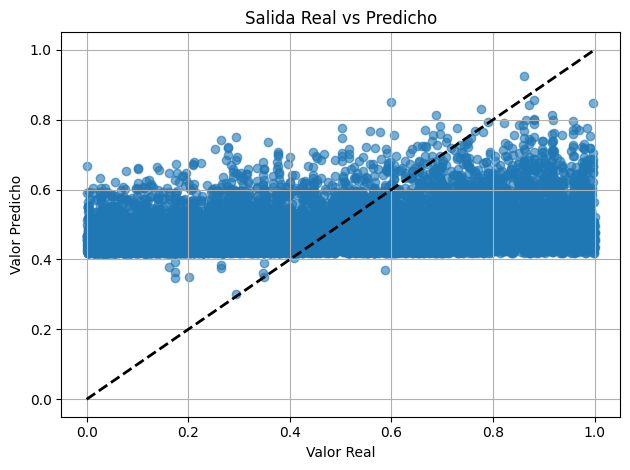

In [ ]:

# Hacer predicciones con el modelo entrenado
y_pred = model.predict(X_val)  # Predicciones en los datos de validación
plt.scatter(y_val_scaled[:, 0], y_pred[:, 0], alpha=0.6)
plt.plot([min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], [min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], 'k--', lw=2)  # Línea de igualdad
plt.title(f'Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.07957344590672306
mae:  0.2454387422883856
rmse:  0.07957344590672306


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

R²: 0.0741
MAPE: 261.42%
SMAPE: 57.72%
